<center><h1>TITANIC SURVIVAL MODEL </h1><center>

<h3> Contents </h3><br>
<b>Introduction</b><br>
<b>1.Import libraries</b><br>
1.1. Functions<br>
<b>2. Data analysis</b><br>
2.1. Dataset overview(Column description)<br>
2.2. Missing values<br>
2.3. Types of independent variables<br>
2.4. Rare labels and Cardinality<br>
2.5. Distribution and outliers <br>
<b>3. Data preprocessing & Feature engineering</b><br>
3.1. Divide dataset on Train & Test sets<br>
3.2. Missing values imputation<br>
3.3. Encoding<br>
3.4. Transformation/Discretization<br>
3.5. Feature Scaling<br>
<b>4. Hyperparameters searching and Model training</b><br>
<b>5. Results</b><br>

<center><h2> Introduction </h2></center>

<h3> Goals and Objectives </h3>

The study aims to develop a model to predict a probability of passengers' survival during the wreck of the Titanic in 1912. To achieve this goal, a number of objectives were identified, including:<br>
1.Analysis of the existing dataset<br>
2.Determining the type of the model (classification or regression)<br>
3.Engineering of the existing features<br>
4.Creating the best-performance model

<h3> Models and Tools </h3>

For the analysis of dataset imputing, encoding, transforming and discreising methods were implemented.
During the research the following classification models were used:
    
Decision Tree Classifier<br>
XGBoost Classifier<br>
Random Forest Classifier<br>
KNN Classifier<br>
AdaBoost Classifier<br>
SVC Classifier<br>
Logistic Regression Classifier<br>
Naive Bayes Classifier

<h3> Results </h3>

According to the accuracy score for test set ( accuracy score is less than 90%), comparison of train/test accuracy score (difference is less than 1.5%) and ROC-AUC (above 83%) for test set <b> AdaBoost Classifier </b> was chosen as the best classification model.

<center><h2> 1. Import libraries </h2></center>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report

#Shapiro-Wilk test
from scipy.stats import shapiro

#Imputers
from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)
from feature_engine.imputation import RandomSampleImputer
from feature_engine import imputation as mdi

#Encoders
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine import encoding as ce

#Transformers
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

#Discretizers
from feature_engine.discretisation import DecisionTreeDiscretiser

#Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#Pipeline
from sklearn.pipeline import Pipeline

#GridSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
#Disable warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Model results list
model_list = list()
train_accuracy_score_list = list()
accuracy_score_list = list()
roc_auc_list = list()

<h3>1.1. Functions</h3>

In [4]:
#Functions used in project

##Calculate mean target per category

def calculate_mean_target_per_category (data, variable):
    total_number_of_labels = len(data)
    
    temp_df = pd.Series(data[variable].value_counts() / total_number_of_labels).reset_index()
    temp_df.columns = [variable, 'perc_of_total']
    temp_df = temp_df.merge(
        data.groupby([variable])['survived'].mean().reset_index(),
        on = variable,
        how = 'left'
    )
    
    return temp_df

##Find normal boundaries

def find_normal_boundaries (data, variable):
    lower_limit = data[variable].mean() - 3*data[variable].std()
    upper_limit = data[variable].mean() + 3*data[variable].std()
    
    return lower_limit, upper_limit

##Find skewed boundaries

def find_skewed_boundaries(data, variable, distance):
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_boundary = data[variable].quantile(0.25) - (IQR*distance)
    upper_boundary = data[variable].quantile(0.75) + (IQR*distance)
    
    return lower_boundary, upper_boundary

<center><h2> 2. Data analysis </h2><center>

<h3>2.1. Dataset overview (Column description) </h3>

In [5]:
#Upload dataset

data = pd.read_csv('../titanic.csv')

In [6]:
# Show first 10 rows

data.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [7]:
#Define variables

print('Current dataset contains: ',len(data.columns),' variables, including:')
print(list(data.columns))


Current dataset contains:  14  variables, including:
['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']


<h4> Definition of variables: </h4><br>
<u> pclass </u> - <i> Ticket class </i><br>
<u> survived </u> - <i> Survival </i><br>
<u> name </u> - <i> Name </i><br>
<u> sex </u> - <i> Sex </i><br>
<u> age </u> - <i> Age in years </i><br>
<u> sibsp </u> - <i> Number of siblings / spouses aboard the Titanic </i><br>
<u> parch </u> - <i> Number of parents / children aboard the Titanic </i><br>
<u> ticket </u> - <i> Ticket number </i><br>
<u> fare </u> - <i> Passenger fare </i><br>
<u> cabin </u> - <i> Cabin number </i><br>
<u> embarked </u> - <i> Port of embarkation </i><br>
<u> boat </u> - <i> Lifeboat number </i><br>
<u> body </u> - <i> Body Identification Number </i><br>
<u> home.dest </u> - <i> Home / Destination </i><br>

In current project <b> survived </b> is dependent variable.

The dependent variable contains  2  unique labels: [1 0]
Percentage of "0" labels: 61.80%
Percentage of "1" labels: 38.20%


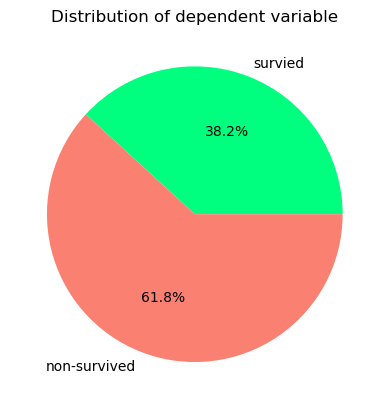

In [8]:
#Analysis of the dependent variable

print('The dependent variable contains ',len(data['survived'].unique()),' unique labels:', data['survived'].unique())

print('Percentage of "0" labels: {:.2%}'.format(list(data['survived']).count(0) / len(data['survived'])))
print('Percentage of "1" labels: {:.2%}'.format(list(data['survived']).count(1) / len(data['survived'])))

survived = list()
survived.append(list(data['survived']).count(1) / len(data['survived']))
survived.append(list(data['survived']).count(0) / len(data['survived']))
survived_labels = ['survied', 'non-survived']
colors=['springgreen', 'salmon']
plt.pie(survived, labels = survived_labels, autopct='%.1f%%', colors = colors)
plt.title('Distribution of dependent variable')
plt.show()

The analysis shows that dependent variable has a binary structure which means that classification model can be used to achieve the goal of the project. However the unequal relation between two labels shows that dataset is not balanced.

In [9]:
# Show general information about dataset 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


The dataset contains both numerical and categorical variables with missing data in both groups.

In [10]:
# Show basic statistical information

data.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
survived,1309.0,0.381971,0.486055,0.0000,0.0000,0.0000,1.000,1.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000


None of the numerical variables has standard deviation equals 0 which could mean that labels inside the variable are all the same. Uncomparable mean values means that variables should be scaled for correct determination of their impact on dependent variable.

<h3> 2.2. Missing values </h3>

In [11]:
# List of variables with missing values

for variable in data:
    percentage_of_missing_values = data[variable].isnull().mean()
    if percentage_of_missing_values > 0:
        print(variable, ' = {:.2%}'.format(percentage_of_missing_values))

age  = 20.09%
fare  = 0.08%
cabin  = 77.46%
embarked  = 0.15%
boat  = 62.87%
body  = 90.76%
home.dest  = 43.09%


In [12]:
#Table

variable_name = data.columns.values.tolist()

perc_missing_values = []
for variable in data:
    number = data[variable].isnull().mean()
    perc_missing_values.append(number)
    
table = pd.DataFrame(
{'variable':variable_name,
'% of missing values':perc_missing_values})

mv_table = table[table['% of missing values'] > 0].reset_index(drop=True)
mv_table = mv_table.sort_values('% of missing values', ascending = False)
mv_table

,variable,% of missing values
5,body,0.907563
2,cabin,0.774637
4,boat,0.628724
6,home.dest,0.430863
0,age,0.200917
3,embarked,0.001528
1,fare,0.000764


Text(0, 0.5, '% of Missing values')

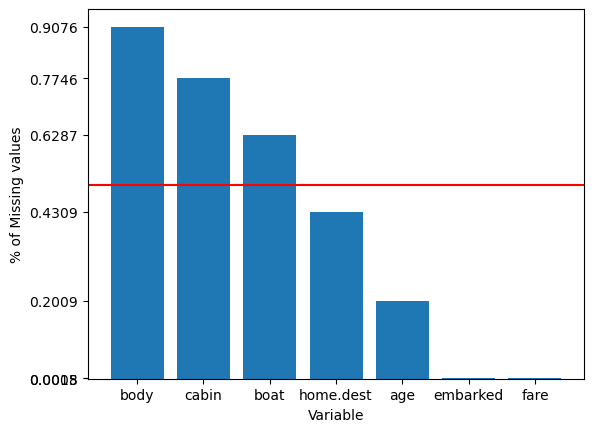

In [13]:
#Figure

plt.bar(mv_table['variable'], mv_table['% of missing values'])
plt.xticks(mv_table['variable'])
plt.yticks(mv_table['% of missing values'])
plt.axhline(y = 0.5,color = 'red')
plt.xlabel('Variable')
plt.ylabel('% of Missing values')

The variables <b>body</b>, <b>cabin</b> and <b>boat</b> have more than 50% of values missing, which means that they can't be used for proper model developing.

In [14]:
#drop variables with number of missing values more than 50%

data_22 = data.drop(['body','cabin','boat'], axis = 1)
data_22.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"


<h3> 2.3. Types of independent variables </h3>

In [15]:
#Types of independent variables


#numerical: discrete & continuous
discrete = [var for var in data_22.columns if data_22[var].dtype != 'O' and var != 'survived' and data_22[var].nunique() < 10]
continuous = [var for var in data_22.columns if data_22[var].dtype != 'O' and var !='survived' and var not in discrete]

#categorical
categorical = [var for var in data_22.columns if data_22[var].dtype == 'O']

print('Current dataset contains:')
print()
print('    {} numerical variables,'.format(len(discrete) + len(continuous)), 'including:')
print('        {} discrete variables:'.format(len(discrete)), list(data_22[discrete].columns))
print('        {} continuous variables:'.format(len(continuous)), list(data_22[continuous].columns))
print()
print('    {} categorical variables:'.format(len(categorical)), list(data_22[categorical].columns))

Current dataset contains:

    5 numerical variables, including:
        3 discrete variables: ['pclass', 'sibsp', 'parch']
        2 continuous variables: ['age', 'fare']

    5 categorical variables: ['name', 'sex', 'ticket', 'embarked', 'home.dest']


<h3> 2.4. Rare labels and Cardinality </h3>

In [16]:
#Show number of labels in each variable

for variable in data_22:
    print(variable, ' - number of labels: ', data_22[variable].nunique())
print()    
print('Total number of labels: ', len(data_22))

pclass  - number of labels:  3
survived  - number of labels:  2
name  - number of labels:  1307
sex  - number of labels:  2
age  - number of labels:  98
sibsp  - number of labels:  7
parch  - number of labels:  8
ticket  - number of labels:  929
fare  - number of labels:  281
embarked  - number of labels:  3
home.dest  - number of labels:  369

Total number of labels:  1309


In [17]:
#Show the share of each label and mean value of dependent variable

for variable in data:
    if variable != 'survived':
        temp_df = calculate_mean_target_per_category(data,variable)
        print(variable)
        print('---------')
        print(temp_df)
        print('---------')

pclass
---------
   pclass  perc_of_total  survived
0       3       0.541635  0.255289
1       1       0.246753  0.619195
2       2       0.211612  0.429603
---------
name
---------
                               name  perc_of_total  survived
0              Connolly, Miss. Kate       0.001528       0.5
1                  Kelly, Mr. James       0.001528       0.0
2     Allen, Miss. Elisabeth Walton       0.000764       1.0
3      Ilmakangas, Miss. Ida Livija       0.000764       0.0
4                  Ilieff, Mr. Ylio       0.000764       0.0
...                             ...            ...       ...
1302         Hart, Miss. Eva Miriam       0.000764       1.0
1303             Harris, Mr. Walter       0.000764       0.0
1304             Harris, Mr. George       0.000764       1.0
1305              Harper, Rev. John       0.000764       0.0
1306             Zimmerman, Mr. Leo       0.000764       0.0

[1307 rows x 3 columns]
---------
sex
---------
      sex  perc_of_total  survived
0 

In [18]:
#Show cardinality

print('Cardinality of categorical variables')
print()

for variable in data_22[categorical].columns:
    print('Number of categories in the variable  "',variable,'"  = {}'.format(len(data_22[variable].unique())))

Cardinality of categorical variables

Number of categories in the variable  " name "  = 1307
Number of categories in the variable  " sex "  = 2
Number of categories in the variable  " ticket "  = 929
Number of categories in the variable  " embarked "  = 4
Number of categories in the variable  " home.dest "  = 370


In [19]:
#Survived-Name correlation
count_map = data_22['name'].value_counts().to_dict()
data_22['name'] = data_22['name'].map(count_map)
print('Correlation coefficient between "survived" and "name": ',data_22['survived'].corr(data_22['name']))

Correlation coefficient between "survived" and "name":  -0.015037773283035832


In [20]:
#Survived-ticket correlation
count_map = data_22['ticket'].value_counts().to_dict()
data_22['ticket'] = data_22['ticket'].map(count_map)
print('Correlation coefficient between "survived" and "ticket": ',data_22['survived'].corr(data_22['ticket']))

Correlation coefficient between "survived" and "ticket":  0.07529329106464326


Variables 'name' and 'ticket' have high cardinality but their correlation coefficient with dependent variable is less than 0.1, so they can be taken out from dataset.

In [21]:
data_24 = data_22.drop(['name', 'ticket'], axis = 1)

In [22]:
data_24.head(5)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,home.dest
0,1,1,female,29.0000,0,0,211.3375,S,"St Louis, MO"
1,1,1,male,0.9167,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,151.5500,S,"Montreal, PQ / Chesterville, ON"


<h3> 2.5. Distribution and outliers </h3>

In [23]:
#Redefine variables after data drop

#numerical: discrete & continuous
discrete = [var for var in data_24.columns if data_24[var].dtype != 'O' and var != 'survived' and data_24[var].nunique() < 10]
continuous = [var for var in data_24.columns if data_24[var].dtype != 'O' and var !=' survived' and var not in discrete]

#categorical
categorical = [var for var in data_24.columns if data_24[var].dtype == 'O']

In [24]:
#Shapiro-Wilk test for distirbution analysis

print('pvalue for numerical variables:')
print()
for variable in data_24:
    if variable in data_24[discrete]:
        variable_swt = data_24[variable].dropna()
        if shapiro(variable_swt).pvalue > 0.05:
            print('variable "',variable, '" is distributed normally, pvalue is more than 0.05 ( pvalue = ',format(shapiro(variable_swt).pvalue, '.4f'),')')
        else:
            print('variable "',variable, '" is not distributed normally, pvalue is less than 0.05 ( pvalue = ',format(shapiro(variable_swt).pvalue, '.4f'),')')
    if variable in data_24[continuous]:
        variable_swt = data_24[variable].dropna()
        if shapiro(variable_swt).pvalue > 0.05:
            print('variable "',variable, '" is distributed normally, pvalue is more than 0.05 ( pvalue = ',format(shapiro(variable_swt).pvalue, '.4f'),')')
        else:
            print('variable "',variable, '" is not distributed normally, pvalue is less than 0.05 ( pvalue = ',format(shapiro(variable_swt).pvalue, '.4f'),')')
   

pvalue for numerical variables:

variable " pclass " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )
variable " survived " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )
variable " age " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )
variable " sibsp " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )
variable " parch " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )
variable " fare " is not distributed normally, pvalue is less than 0.05 ( pvalue =  0.0000 )


<b> Distribution visualisation

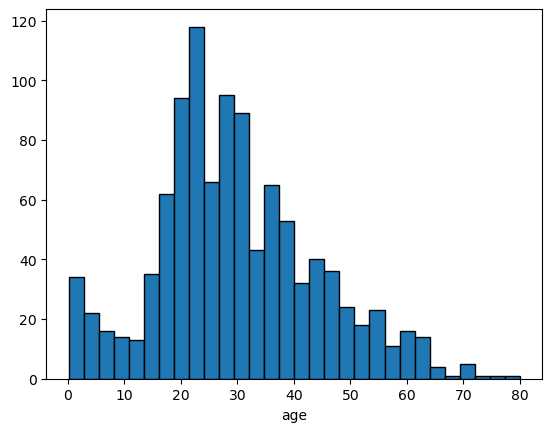

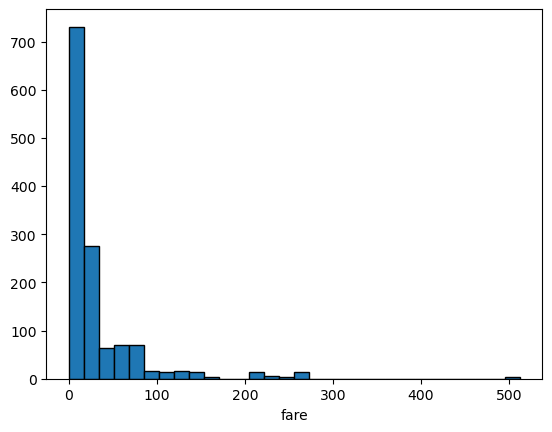

In [25]:
#Distribution of continuous variables

for variable in data_24:
    if variable in data_24[continuous] and variable != 'survived':
        plt.hist(data_24[variable], edgecolor = 'black', bins=30)
        plt.xlabel(variable)
        plt.show()

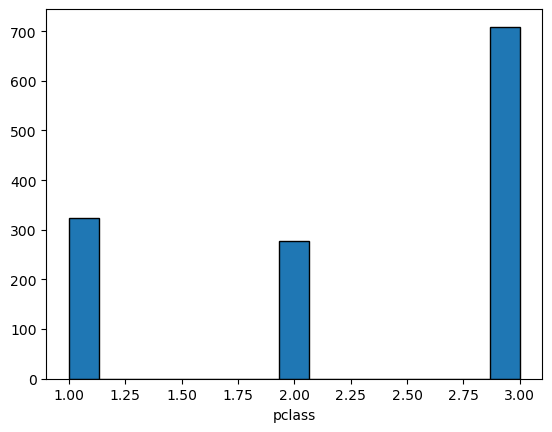

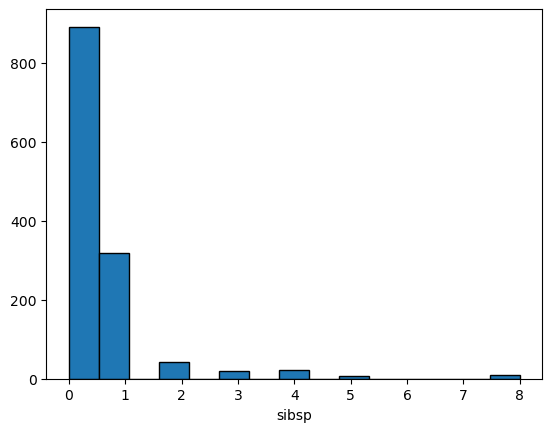

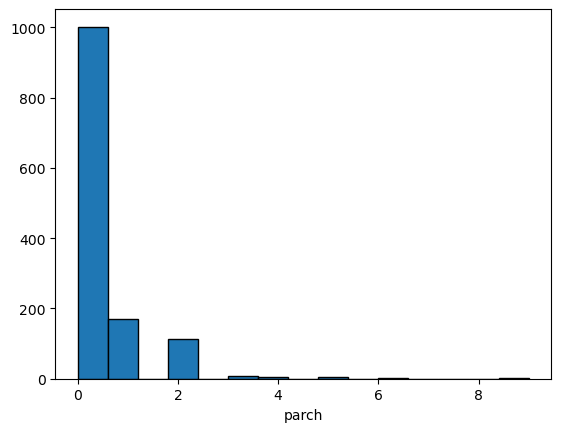

In [26]:
#Distribution of discrete variables

for variable in data_24:
    if variable in data_24[discrete] and variable != 'survived':
        plt.hist(data_24[variable], edgecolor = 'black', bins=15)
        plt.xlabel(variable)
        plt.show()

The analysis above shows that all numerical variables have skewed distribution.

In [27]:
for variable in data_24[discrete]:
    distance = 1.5
    print(variable, find_skewed_boundaries(data, variable, distance))

pclass (0.5, 4.5)
sibsp (-1.5, 2.5)
parch (0.0, 0.0)


<Axes: >

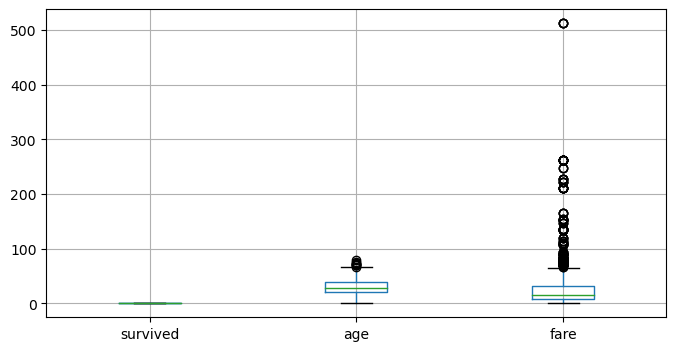

In [28]:
# Outliers in continuous variables

data_24[continuous].boxplot(figsize = (8, 4))

<Axes: >

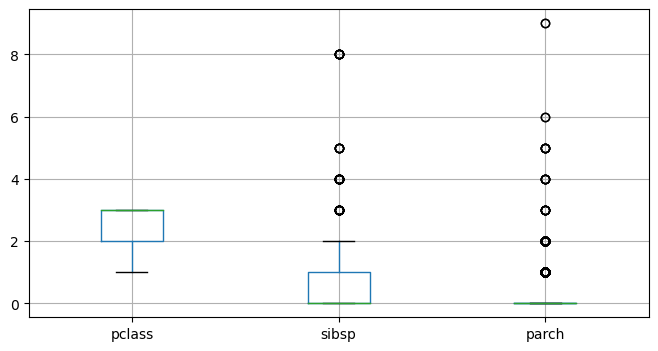

In [29]:
# Outliers in discrete variables

data_24[discrete].boxplot(figsize = (8, 4))

According to the analysis 4 out of 5 numerical variables have outliers

<center><h2> 3. Data preprocessing & Feature engineering </h2><center>

<h3>3.1. Divide dataset on Train & Test sets </h3>

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    data_24.drop(['survived'], axis = 1),
    data_24['survived'],
    test_size = 0.3,
    random_state = 0
)

X_train.shape, X_test.shape

((916, 8), (393, 8))

<h3>3.2. Missing values imputation</h3>

In [31]:
#Missing values imputation in numerical variables

X_train.select_dtypes(exclude = 'O').isnull().mean()

pclass    0.000000
age       0.191048
sibsp     0.000000
parch     0.000000
fare      0.000000
dtype: float64

Only one variable ('age') in numerical variables in Train set has missing values.

5.141604919600695e-09
1.191000109881826e-15
3.485340069370963e-17


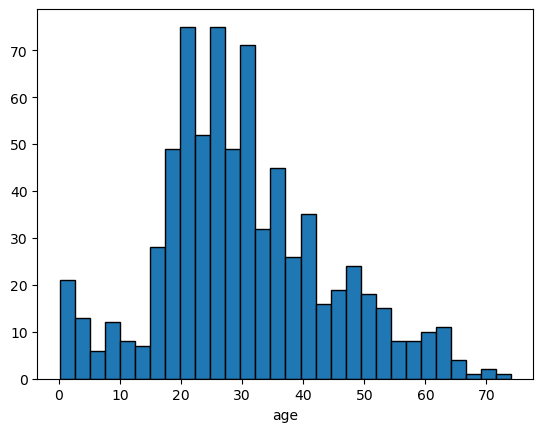

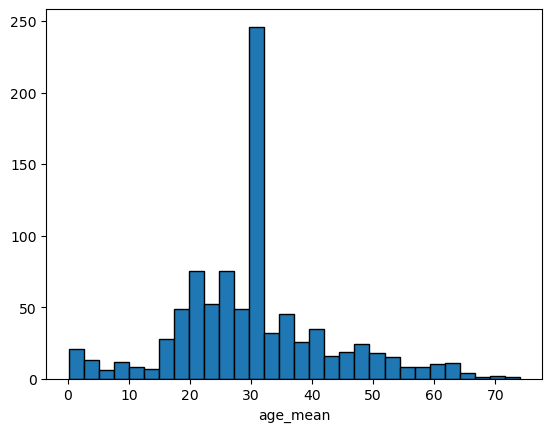

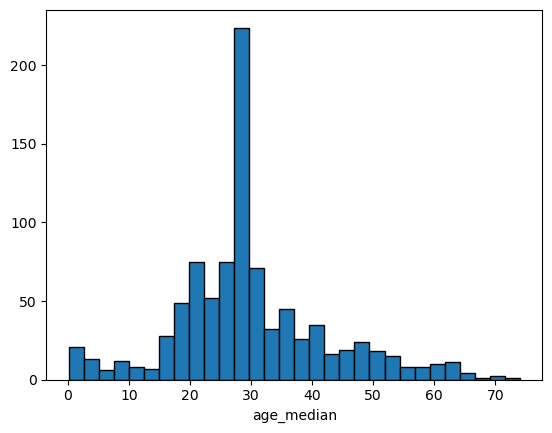

In [32]:
# MeanMedianImputer('mean')
mean = X_train['age'].mean()
X_train['age_mean'] = X_train['age'].fillna(mean)

# MeanMedianImputer ('median')
median = X_train['age'].median()
X_train['age_median'] = X_train['age'].fillna(median)

print(shapiro(X_train['age'].dropna()).pvalue)
print(shapiro(X_train['age_mean']).pvalue)
print(shapiro(X_train['age_median']).pvalue)

# Visualization of distribution of variable before and after imputation methods

plt.hist(X_train['age'], edgecolor = 'black', bins=30)
plt.xlabel('age')
plt.show()

plt.hist(X_train['age_mean'], edgecolor = 'black', bins=30)
plt.xlabel('age_mean')
plt.show()

plt.hist(X_train['age_median'], edgecolor = 'black', bins=30)
plt.xlabel('age_median')
plt.show()

In [33]:
X_train_32 = X_train
X_train_32

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest,age_mean,age_median
501,2,female,13.0000,0,1,19.5000,S,"England / Bennington, VT",13.000000,13.0000
588,2,female,4.0000,1,1,23.0000,S,"Cornwall / Akron, OH",4.000000,4.0000
402,2,female,30.0000,1,0,13.8583,C,"Barcelona, Spain / Havana, Cuba",30.000000,30.0000
1193,3,male,NaN,0,0,7.7250,Q,NaN,30.231444,28.0000
686,3,female,22.0000,0,0,7.7250,Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls...",22.000000,22.0000
...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,S,"Devon, England Wichita, KS",0.166700,0.1667
835,3,male,NaN,0,0,8.0500,S,NaN,30.231444,28.0000
1216,3,female,NaN,0,0,7.7333,Q,NaN,30.231444,28.0000
559,2,female,20.0000,0,0,36.7500,S,"Cornwall / Hancock, MI",20.000000,20.0000


In [34]:
X_train_32['age'] = X_train_32['age_mean']
X_train_32 = X_train_32.drop(['age_median'], axis = 1)
X_train_32 = X_train_32.drop(['age_mean'], axis = 1)
X_train_32

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest
501,2,female,13.000000,0,1,19.5000,S,"England / Bennington, VT"
588,2,female,4.000000,1,1,23.0000,S,"Cornwall / Akron, OH"
402,2,female,30.000000,1,0,13.8583,C,"Barcelona, Spain / Havana, Cuba"
1193,3,male,30.231444,0,0,7.7250,Q,NaN
686,3,female,22.000000,0,0,7.7250,Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."
...,...,...,...,...,...,...,...,...
763,3,female,0.166700,1,2,20.5750,S,"Devon, England Wichita, KS"
835,3,male,30.231444,0,0,8.0500,S,NaN
1216,3,female,30.231444,0,0,7.7333,Q,NaN
559,2,female,20.000000,0,0,36.7500,S,"Cornwall / Hancock, MI"


In [35]:
X_train_32['age'].isnull().mean()

0.0

In [36]:
#Missing values imputation in categorical variables

X_train_32.select_dtypes(include = 'O').isnull().mean()

sex          0.000000
embarked     0.002183
home.dest    0.424672
dtype: float64

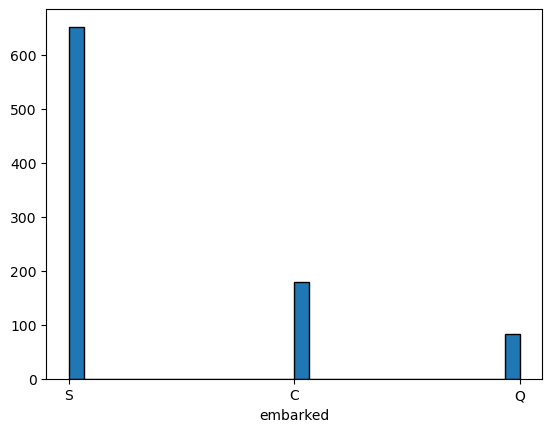

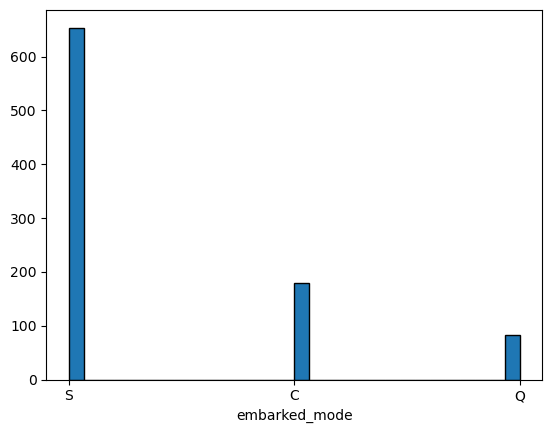

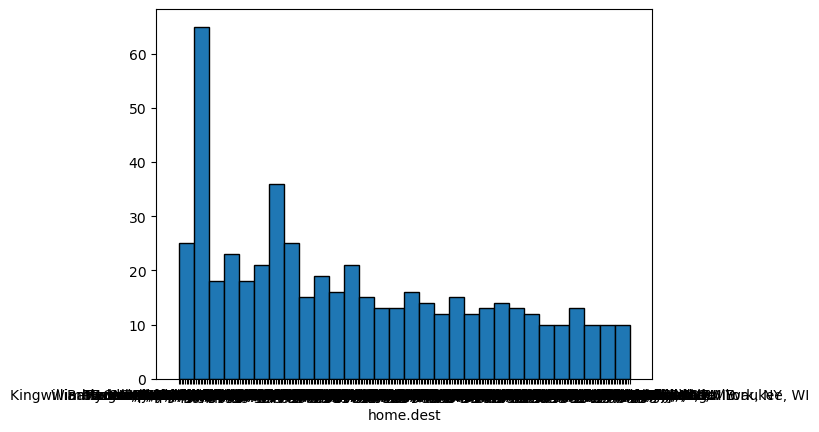

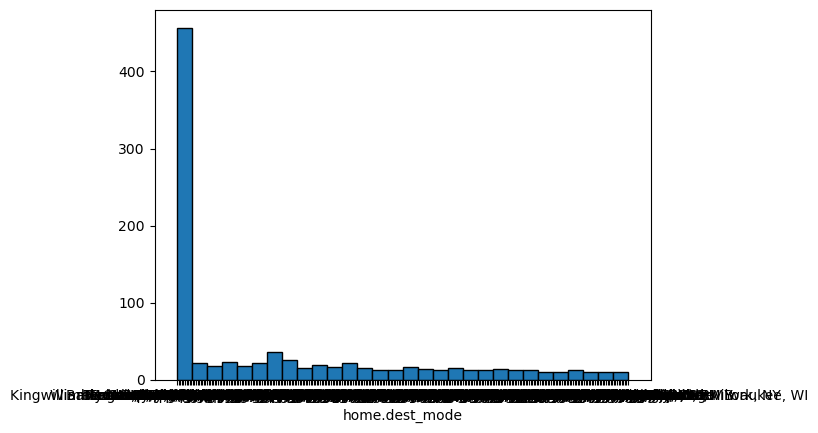

In [37]:
# CategoricalImputer ('frequent')

X_train_32['embarked_mode'] = X_train_32['embarked'].fillna(X_train_32['embarked'].mode()[0])
X_train_32['home.dest_mode'] = X_train_32['home.dest'].fillna(X_train_32['home.dest'].mode()[0])

# Visualization of distribution of variable before and after imputation methods

plt.hist(X_train_32['embarked'].dropna(), edgecolor = 'black', bins=30)
plt.xlabel('embarked')
plt.show()

plt.hist(X_train_32['embarked_mode'], edgecolor = 'black', bins=30)
plt.xlabel('embarked_mode')
plt.show()

plt.hist(X_train_32['home.dest'].dropna(), edgecolor = 'black', bins=30)
plt.xlabel('home.dest')
plt.show()

plt.hist(X_train_32['home.dest_mode'], edgecolor = 'black', bins=30)
plt.xlabel('home.dest_mode')
plt.show()

In [38]:
X_train_32

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest,embarked_mode,home.dest_mode
501,2,female,13.000000,0,1,19.5000,S,"England / Bennington, VT",S,"England / Bennington, VT"
588,2,female,4.000000,1,1,23.0000,S,"Cornwall / Akron, OH",S,"Cornwall / Akron, OH"
402,2,female,30.000000,1,0,13.8583,C,"Barcelona, Spain / Havana, Cuba",C,"Barcelona, Spain / Havana, Cuba"
1193,3,male,30.231444,0,0,7.7250,Q,NaN,Q,"New York, NY"
686,3,female,22.000000,0,0,7.7250,Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls...",Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."
...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.166700,1,2,20.5750,S,"Devon, England Wichita, KS",S,"Devon, England Wichita, KS"
835,3,male,30.231444,0,0,8.0500,S,NaN,S,"New York, NY"
1216,3,female,30.231444,0,0,7.7333,Q,NaN,Q,"New York, NY"
559,2,female,20.000000,0,0,36.7500,S,"Cornwall / Hancock, MI",S,"Cornwall / Hancock, MI"


In [39]:
X_train_32['embarked'] = X_train_32['embarked_mode']
X_train_32 = X_train_32.drop(['embarked_mode'], axis = 1)
X_train_32['home.dest'] = X_train_32['home.dest_mode']
X_train_32 = X_train_32.drop(['home.dest_mode'], axis = 1)
X_train_32

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest
501,2,female,13.000000,0,1,19.5000,S,"England / Bennington, VT"
588,2,female,4.000000,1,1,23.0000,S,"Cornwall / Akron, OH"
402,2,female,30.000000,1,0,13.8583,C,"Barcelona, Spain / Havana, Cuba"
1193,3,male,30.231444,0,0,7.7250,Q,"New York, NY"
686,3,female,22.000000,0,0,7.7250,Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."
...,...,...,...,...,...,...,...,...
763,3,female,0.166700,1,2,20.5750,S,"Devon, England Wichita, KS"
835,3,male,30.231444,0,0,8.0500,S,"New York, NY"
1216,3,female,30.231444,0,0,7.7333,Q,"New York, NY"
559,2,female,20.000000,0,0,36.7500,S,"Cornwall / Hancock, MI"


<h3>3.3. Encoding</h3>

In [40]:
X_train_32

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest
501,2,female,13.000000,0,1,19.5000,S,"England / Bennington, VT"
588,2,female,4.000000,1,1,23.0000,S,"Cornwall / Akron, OH"
402,2,female,30.000000,1,0,13.8583,C,"Barcelona, Spain / Havana, Cuba"
1193,3,male,30.231444,0,0,7.7250,Q,"New York, NY"
686,3,female,22.000000,0,0,7.7250,Q,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."
...,...,...,...,...,...,...,...,...
763,3,female,0.166700,1,2,20.5750,S,"Devon, England Wichita, KS"
835,3,male,30.231444,0,0,8.0500,S,"New York, NY"
1216,3,female,30.231444,0,0,7.7333,Q,"New York, NY"
559,2,female,20.000000,0,0,36.7500,S,"Cornwall / Hancock, MI"


In [41]:
X_train_32['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [42]:
X_train_32['home.dest'].unique()

array(['England / Bennington, VT', 'Cornwall / Akron, OH',
       'Barcelona, Spain / Havana, Cuba', 'New York, NY',
       'Kingwilliamstown, Co Cork, Ireland Glens Falls, NY',
       'Plymouth, Devon / Detroit, MI', 'Haverford, PA', 'St Louis, MO',
       'Weston-Super-Mare, Somerset', 'Montreal, PQ / Chesterville, ON',
       'Oslo, Norway Bayonne, NJ', 'England', 'Southsea, Hants',
       'Syria New York, NY', 'Greece', 'Cologne, Germany', 'Southampton',
       'Basel, Switzerland', 'Trenton, NJ', 'Philadelphia, PA',
       'Salo, Finland Astoria, OR', 'Bronx, NY',
       'Ruotsinphytaa, Finland New York, NY', 'Belfast', 'Vancouver, BC',
       'Wimbledon Park, London / Hayling Island, Hants',
       'New York, NY / Ithaca, NY', 'Paris / Haiti',
       'Windsor, England New York, NY', 'Minneapolis, MN',
       'New York, NY /  Stamford CT', 'Bournmouth, England',
       'Antwerp, Belgium / Stanton, OH', 'Paris, France',
       'England Albion, NY', 'Portugal', 'Ireland Brooklyn, NY

In [43]:
#Count encoding

X_train_34 = X_train_32

count_map = X_train_32['embarked'].value_counts().to_dict()
X_train_34['embarked'] = X_train_32['embarked'].map(count_map)

count_map = X_train_32['home.dest'].value_counts().to_dict()
X_train_34['home.dest'] = X_train_32['home.dest'].map(count_map)

X_train_34

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest
501,2,female,13.000000,0,1,19.5000,654,2
588,2,female,4.000000,1,1,23.0000,654,5
402,2,female,30.000000,1,0,13.8583,179,2
1193,3,male,30.231444,0,0,7.7250,83,433
686,3,female,22.000000,0,0,7.7250,83,1
...,...,...,...,...,...,...,...,...
763,3,female,0.166700,1,2,20.5750,654,3
835,3,male,30.231444,0,0,8.0500,654,433
1216,3,female,30.231444,0,0,7.7333,83,433
559,2,female,20.000000,0,0,36.7500,654,2


In [44]:
#Get dummies encoding

X_train_34 = pd.get_dummies(X_train_34, drop_first = True, dtype = int)
X_train_34.head(10)

,pclass,age,sibsp,parch,fare,embarked,home.dest,sex_male
501,2,13.000000,0,1,19.5000,654,2,0
588,2,4.000000,1,1,23.0000,654,5,0
402,2,30.000000,1,0,13.8583,179,2,0
1193,3,30.231444,0,0,7.7250,83,433,1
686,3,22.000000,0,0,7.7250,83,1,0
971,3,30.231444,0,0,7.8792,83,433,1
117,1,30.000000,0,0,56.9292,179,433,0
540,2,2.000000,1,1,26.0000,654,2,0
294,1,49.000000,1,1,110.8833,179,3,1
261,1,35.000000,0,0,26.2875,654,4,1


<Axes: >

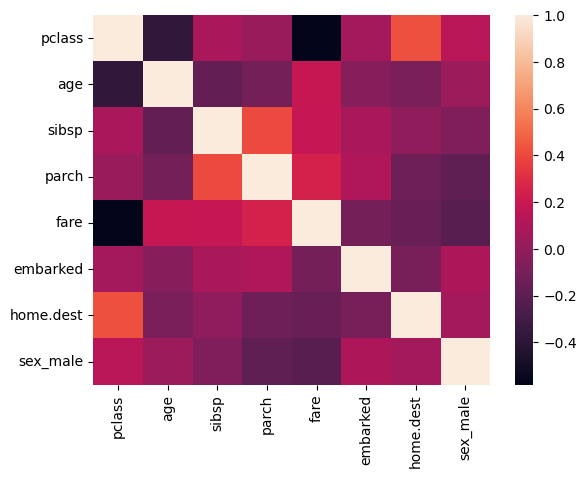

In [45]:
#Correlation matrix

import seaborn as sns
corr = X_train_34.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#add numbers to plot

In [46]:
#Dependent variable correlation
for variable in X_train_34:
    print('Correlation coefficient between "survived" and "', variable, '": ',y_train.corr(X_train_34[variable]))

Correlation coefficient between "survived" and " pclass ":  -0.3097346181512482
Correlation coefficient between "survived" and " age ":  -0.018281552609949816
Correlation coefficient between "survived" and " sibsp ":  -0.06988756318393864
Correlation coefficient between "survived" and " parch ":  0.0615657883927588
Correlation coefficient between "survived" and " fare ":  0.24146675835376247
Correlation coefficient between "survived" and " embarked ":  -0.13378204049862255
Correlation coefficient between "survived" and " home.dest ":  -0.14343768712380106
Correlation coefficient between "survived" and " sex_male ":  -0.5351382059530202


Variables 'sibsp', 'parch', 'embarked' and 'home.dest' has a small correlation with dependent variable, so they can be dropped.

In [47]:
X_train_35 = X_train_34.drop(['sibsp','parch','embarked','home.dest'], axis = 1)

In [48]:
X_train_35

,pclass,age,fare,sex_male
501,2,13.000000,19.5000,0
588,2,4.000000,23.0000,0
402,2,30.000000,13.8583,0
1193,3,30.231444,7.7250,1
686,3,22.000000,7.7250,0
...,...,...,...,...
763,3,0.166700,20.5750,0
835,3,30.231444,8.0500,1
1216,3,30.231444,7.7333,0
559,2,20.000000,36.7500,0


<h3>3.4. Transformation/Discretization</h3>

In [49]:
import scipy.stats as stats

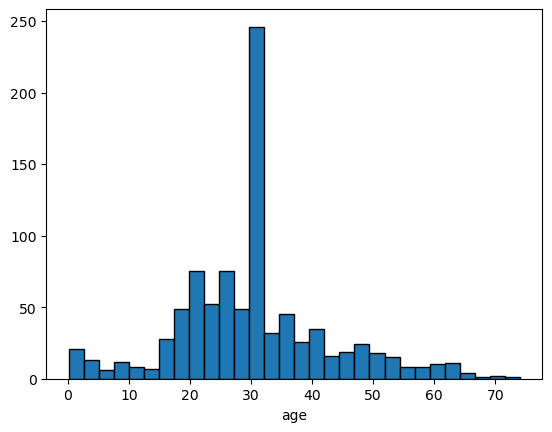

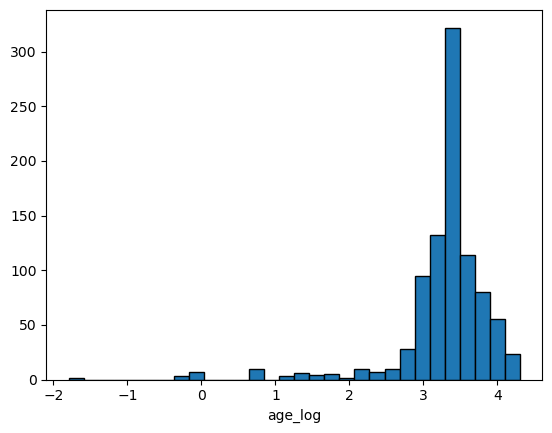

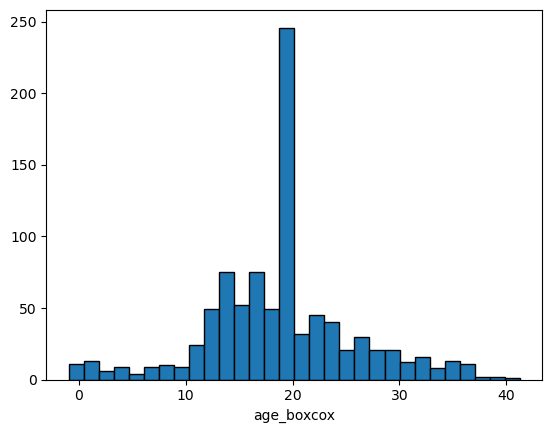

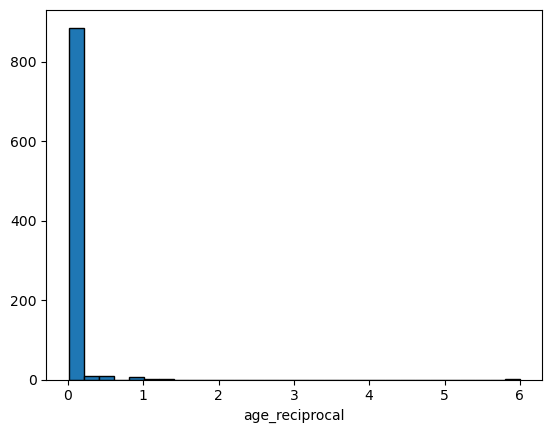

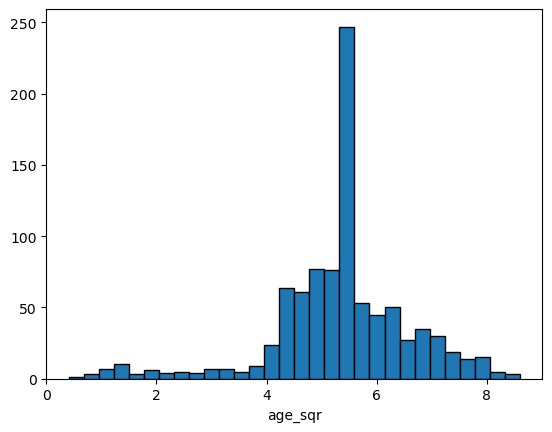

In [50]:
#age transformation
X_train_35['age_log'] = np.log(X_train_35['age'])
X_train_35['age_boxcox'], param = stats.boxcox(X_train_35['age'])
X_train_35['age_reciprocal'] = 1 / X_train_35['age']
X_train_35['age_sqr'] = X_train_35['age']**(1/2)


plt.hist(X_train_35['age'], edgecolor = 'black', bins=30)
plt.xlabel('age')
plt.show()

plt.hist(X_train_35['age_log'], edgecolor = 'black', bins=30)
plt.xlabel('age_log')
plt.show()

plt.hist(X_train_35['age_boxcox'], edgecolor = 'black', bins=30)
plt.xlabel('age_boxcox')
plt.show()

plt.hist(X_train_35['age_reciprocal'], edgecolor = 'black', bins=30)
plt.xlabel('age_reciprocal')
plt.show()

plt.hist(X_train_35['age_sqr'], edgecolor = 'black', bins=30)
plt.xlabel('age_sqr')
plt.show()


#choose age_boxcox

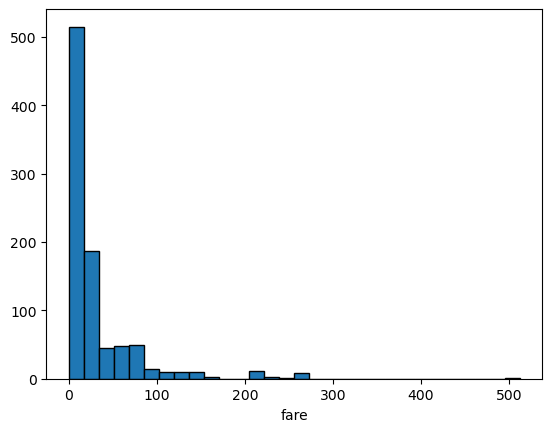

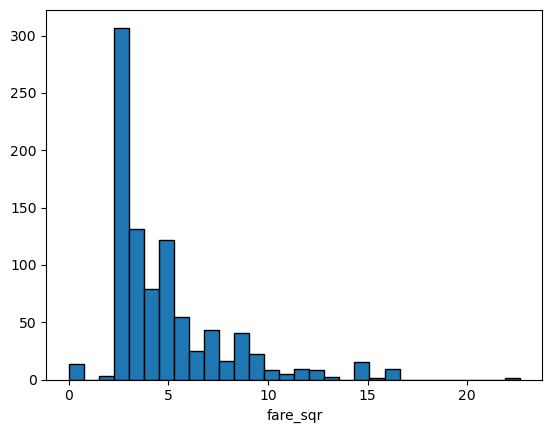

In [51]:
#fare transformation
X_train_35['fare_sqr'] = X_train_35['fare']**(1/2)


plt.hist(X_train_35['fare'], edgecolor = 'black', bins=30)
plt.xlabel('fare')
plt.show()

plt.hist(X_train_35['fare_sqr'], edgecolor = 'black', bins=30)
plt.xlabel('fare_sqr')
plt.show()


#choose fare_sqr

In [52]:
X_train_35

,pclass,age,fare,sex_male,age_log,age_boxcox,age_reciprocal,age_sqr,fare_sqr
501,2,13.000000,19.5000,0,2.564949,8.874353,0.076923,3.605551,4.415880
588,2,4.000000,23.0000,0,1.386294,2.595822,0.250000,2.000000,4.795832
402,2,30.000000,13.8583,0,3.401197,18.923603,0.033333,5.477226,3.722674
1193,3,30.231444,7.7250,1,3.408883,19.051943,0.033078,5.498313,2.779388
686,3,22.000000,7.7250,0,3.091042,14.369465,0.045455,4.690416,2.779388
...,...,...,...,...,...,...,...,...,...
763,3,0.166700,20.5750,0,-1.791559,-0.934488,5.998800,0.408289,4.535967
835,3,30.231444,8.0500,1,3.408883,19.051943,0.033078,5.498313,2.837252
1216,3,30.231444,7.7333,0,3.408883,19.051943,0.033078,5.498313,2.780881
559,2,20.000000,36.7500,0,2.995732,13.188897,0.050000,4.472136,6.062178


In [53]:
X_train_35['fare'] = X_train_35['fare_sqr']
X_train_35['age'] = X_train_35['age_boxcox']

X_train_35 = X_train_35.drop(['age_log','age_reciprocal','age_sqr','age_boxcox','fare_sqr'], axis = 1)


In [54]:
X_train_35

,pclass,age,fare,sex_male
501,2,8.874353,4.415880,0
588,2,2.595822,4.795832,0
402,2,18.923603,3.722674,0
1193,3,19.051943,2.779388,1
686,3,14.369465,2.779388,0
...,...,...,...,...
763,3,-0.934488,4.535967,0
835,3,19.051943,2.837252,1
1216,3,19.051943,2.780881,0
559,2,13.188897,6.062178,0


In [55]:
#age discretisation

treeDisc = DecisionTreeDiscretiser(
    cv = 10,
    scoring = 'accuracy',
    variables = ['age'],
    regression = False
)

treeDisc.fit(X_train_35, y_train)

DecisionTreeDiscretiser(cv=10, regression=False, scoring='accuracy',
                        variables=['age'])

In [56]:
train_t = treeDisc.transform(X_train_35)

In [57]:
train_t.head(10)

,pclass,age,fare,sex_male
501,2,0.382199,4.415880,0
588,2,0.589744,4.795832,0
402,2,0.382199,3.722674,0
1193,3,0.267045,2.779388,1
686,3,0.382199,2.779388,0
971,3,0.267045,2.806991,1
117,1,0.382199,7.545144,0
540,2,0.589744,5.099020,0
294,1,0.436482,10.530114,1
261,1,0.436482,5.127134,1


In [58]:
X_train_35 = train_t

In [59]:
X_train_35.head(10)

,pclass,age,fare,sex_male
501,2,0.382199,4.415880,0
588,2,0.589744,4.795832,0
402,2,0.382199,3.722674,0
1193,3,0.267045,2.779388,1
686,3,0.382199,2.779388,0
971,3,0.267045,2.806991,1
117,1,0.382199,7.545144,0
540,2,0.589744,5.099020,0
294,1,0.436482,10.530114,1
261,1,0.436482,5.127134,1


<h3>3.5. Feature Scaling</h3>

In [60]:
#StandardScaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_36 = scaler.fit_transform(X_train_35)

#test another Scalers
X_train_35 = pd.DataFrame(X_train_35)

In [61]:
X_train_36 = pd.DataFrame(X_train_36, columns = X_train_35.columns)

In [62]:
X_train_36

,pclass,age,fare,sex_male
0,-0.347430,-0.035368,-0.157018,-1.316939
1,-0.347430,2.278609,-0.028363,-1.316939
2,-0.347430,-0.035368,-0.391746,-1.316939
3,0.840055,-1.319249,-0.711153,0.759337
4,0.840055,-0.035368,-0.711153,-1.316939
...,...,...,...,...
911,0.840055,2.278609,-0.116356,-1.316939
912,0.840055,-1.319249,-0.691560,0.759337
913,0.840055,-1.319249,-0.710648,-1.316939
914,-0.347430,-0.035368,0.400436,-1.316939


In [63]:
X_train_36.describe().T

,count,mean,std,min,25%,50%,75%,max
pclass,916.0,1.163553e-16,1.000546,-1.534915,-1.534915,0.840055,0.840055,0.840055
age,916.0,-2.850704e-16,1.000546,-4.296619,-0.035368,-0.035368,0.569851,6.852681
fare,916.0,-1.628974e-16,1.000546,-1.652285,-0.700806,-0.364930,0.241366,6.012077
sex_male,916.0,-2.908881e-17,1.000546,-1.316939,-1.316939,0.759337,0.759337,0.759337


In [64]:
scaler_mean = StandardScaler(with_mean =True, with_std = False)
scaler_minmax = RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))

scaler_mean.fit(X_train_35)
scaler_minmax.fit(X_train_35)

X_train_35_scaled = scaler_minmax.transform(scaler_mean.transform(X_train_35))

X_train_35_scaled = pd.DataFrame(X_train_35_scaled, columns = X_train_35.columns)

np.round(X_train_35_scaled.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
pclass,916.0,0.0,0.4,-0.6,-0.6,0.4,0.4,0.4
age,916.0,-0.0,0.1,-0.4,-0.0,-0.0,0.1,0.6
fare,916.0,-0.0,0.1,-0.2,-0.1,-0.0,0.0,0.8
sex_male,916.0,-0.0,0.5,-0.6,-0.6,0.4,0.4,0.4


<center><h2> 4. Hyperparameters searching and Model training </h2><center>

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['survived', 'name', 'sibsp', 'parch', 'ticket', 'cabin', 'embarked', 'boat', 'body', 'home.dest'], axis = 1),
    data['survived'],
    test_size = 0.3,
    random_state = 0
)

X_train.shape, X_test.shape

((916, 4), (393, 4))

In [66]:
X_train

,pclass,sex,age,fare
501,2,female,13.0000,19.5000
588,2,female,4.0000,23.0000
402,2,female,30.0000,13.8583
1193,3,male,NaN,7.7250
686,3,female,22.0000,7.7250
...,...,...,...,...
763,3,female,0.1667,20.5750
835,3,male,NaN,8.0500
1216,3,female,NaN,7.7333
559,2,female,20.0000,36.7500


In [67]:
X_test

,pclass,sex,age,fare
1139,3,male,38.0,7.8958
533,2,female,21.0,21.0000
459,2,male,42.0,27.0000
1150,3,male,NaN,14.5000
393,2,male,25.0,31.5000
...,...,...,...,...
914,3,male,33.0,7.8542
580,2,female,31.0,21.0000
1080,3,male,NaN,7.7500
1249,3,male,NaN,7.7500


In [68]:
X_train['fare'] = X_train['fare']**(1/2)
X_test['fare'] = X_test['fare']**(1/2)
X_train['age'], param = stats.boxcox(X_train['age'])
X_test['age'], param = stats.boxcox(X_test['age'])

In [69]:
X_train

,pclass,sex,age,fare
501,2,female,3.232112e+08,4.415880
588,2,female,1.488462e+04,4.795832
402,2,female,3.858149e+11,3.722674
1193,3,male,NaN,2.779388
686,3,female,2.787368e+10,2.779388
...,...,...,...,...
763,3,female,-1.180340e-01,4.535967
835,3,male,NaN,2.837252
1216,3,female,NaN,2.780881
559,2,female,1.243111e+10,6.062178


In [70]:
X_train_copy = X_train
X_test_copy = X_test

<h3> Decision Tree Classifier </h3>

In [71]:
#Create pipeline
DTC_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
DTC_pipe.fit(X_train, y_train)


#GridSearch
parameters = [
    {
     'classifier__criterion' : ["gini","entropy","log_loss"],
     'classifier__splitter' : ["best","random"]
     }
]

grid_search = GridSearchCV(
    estimator = DTC_pipe,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'classifier__criterion': 'gini', 'classifier__splitter': 'best'}


Accuracy score: 0.7989821882951654


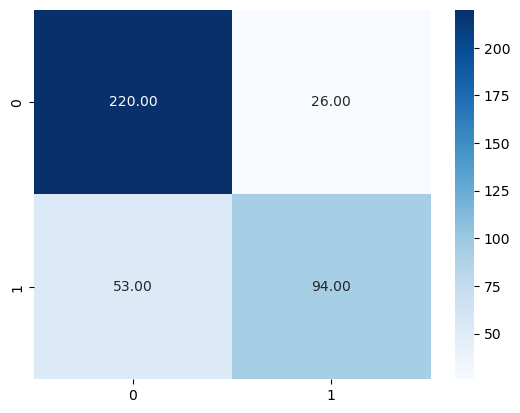

In [72]:
#Repeat pipeline with best parameters
DTC_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', DecisionTreeClassifier(criterion='gini', splitter = 'best', random_state=0))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline Train
DTC_pipe.fit(X_train, y_train)

#Prediction

y_pred = DTC_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = DTC_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [73]:
model_list.append('Decision Tree Classifier')
accuracy_score_list.append(ac)

In [74]:
probs = DTC_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.785


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       246
           1       0.78      0.64      0.70       147

    accuracy                           0.80       393
   macro avg       0.79      0.77      0.78       393
weighted avg       0.80      0.80      0.79       393



<h3> Random Forest Classifier </h3>

In [76]:
#Create pipeline
RF_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
RF_pipe.fit(X_train, y_train)


#GridSearch
parameters = [
    {
     'classifier__criterion' : ["gini","entropy","log_loss"]
     }
]

grid_search = GridSearchCV(
    estimator = RF_pipe,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'classifier__criterion': 'gini'}


Accuracy score: 0.7862595419847328


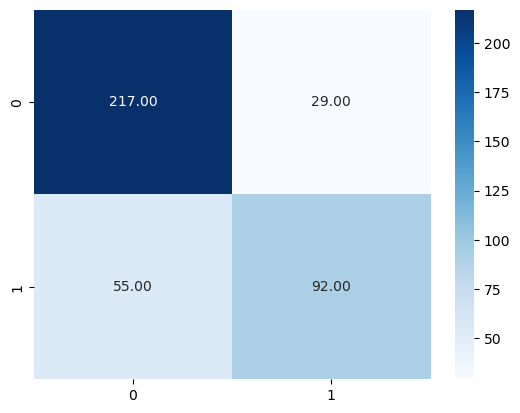

In [77]:
#Repeat pipeline with best parameters
RF_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', RandomForestClassifier(n_estimators=10, criterion='gini', random_state=0))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline Train
RF_pipe.fit(X_train, y_train)

#Prediction

y_pred = RF_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = RF_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [78]:
model_list.append('Random Forest Classifier')
accuracy_score_list.append(ac)

In [79]:
probs = RF_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.807


In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       246
           1       0.76      0.63      0.69       147

    accuracy                           0.79       393
   macro avg       0.78      0.75      0.76       393
weighted avg       0.78      0.79      0.78       393



<h3> SVC </h3>

In [81]:
#Create pipeline
SVC_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', SVC(kernel = 'linear',random_state = 0,probability = True))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
SVC_pipe.fit(X_train, y_train)


#GridSearch
parameters = [
    {
     'classifier__C':[0.25, 0.5, 0.75, 1],
     'classifier__kernel':['linear', 'rbf']
     }
]

grid_search = GridSearchCV(
    estimator = SVC_pipe,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'classifier__C': 0.5, 'classifier__kernel': 'rbf'}


Accuracy score: 0.7888040712468194


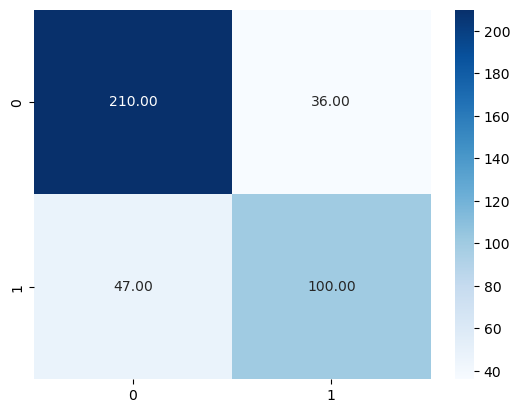

In [82]:
#Repeat pipeline with best parameters
SVC_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', SVC(kernel = 'rbf',C = 0.5,random_state = 0,probability = True))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline Train
SVC_pipe.fit(X_train, y_train)

#Prediction

y_pred = SVC_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = SVC_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [83]:
model_list.append('SVC Classifier')
accuracy_score_list.append(ac)

In [84]:
probs = SVC_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.820


In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       246
           1       0.74      0.68      0.71       147

    accuracy                           0.79       393
   macro avg       0.78      0.77      0.77       393
weighted avg       0.79      0.79      0.79       393



<h3> KNN </h3>

In [86]:
#Create pipeline
KNN_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
KNN_pipe.fit(X_train, y_train)


#GridSearch
parameters = [
    {
     'classifier__weights':['uniform','distance'],
     'classifier__algorithm':['ball_tree','kd_tree']
     }
]

grid_search = GridSearchCV(
    estimator = KNN_pipe,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print('Best parameters: ', best_parameters)

model = grid_search.best_estimator_

Best parameters:  {'classifier__algorithm': 'ball_tree', 'classifier__weights': 'uniform'}


Accuracy score: 0.7837150127226463


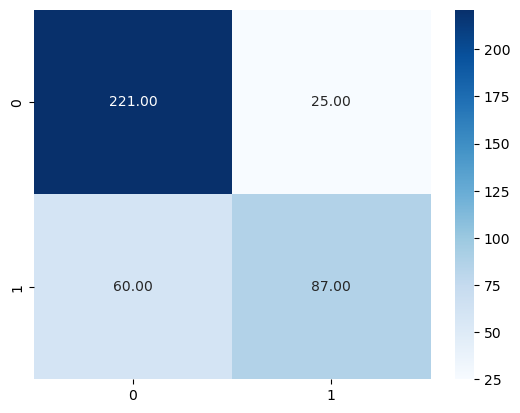

In [87]:
#Repeat pipeline with best parameters
KNN_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', KNeighborsClassifier(algorithm = 'ball_tree', weights = 'uniform', n_neighbors = 5, metric = 'minkowski', p = 2))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline Train
KNN_pipe.fit(X_train, y_train)

#Prediction

y_pred = KNN_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = KNN_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [88]:
model_list.append('KNN Classifier')
accuracy_score_list.append(ac)

In [89]:
probs = KNN_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.823


In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       246
           1       0.78      0.59      0.67       147

    accuracy                           0.78       393
   macro avg       0.78      0.75      0.76       393
weighted avg       0.78      0.78      0.78       393



<h3> Logistic Regression </h3>

In [91]:
#Create pipeline
Logit_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', LogisticRegression(random_state = 0))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
Logit_pipe.fit(X_train, y_train)


#GridSearch
##None

Pipeline(steps=[('imputer_age',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['age', 'fare'])),
                ('encoder_sex',
                 OneHotEncoder(drop_last=True, variables=['sex'])),
                ('discretiser_age',
                 DecisionTreeDiscretiser(cv=10, regression=False,
                                         scoring='accuracy',
                                         variables=['age'])),
                ('scaler',
                 RobustScaler(quantile_range=(0, 100), with_centering=False)),
                ('classifier', LogisticRegression(random_state=0))])

Accuracy score: 0.7786259541984732


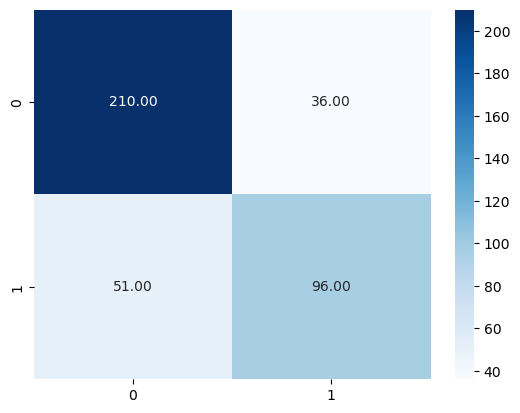

In [92]:
#Prediction

y_pred = Logit_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = Logit_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [93]:
model_list.append('Logistic Regression Classifier')
accuracy_score_list.append(ac)

In [94]:
probs = Logit_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.830


In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       246
           1       0.73      0.65      0.69       147

    accuracy                           0.78       393
   macro avg       0.77      0.75      0.76       393
weighted avg       0.78      0.78      0.78       393



<h3> Naive Bayes </h3>

In [96]:
#Create pipeline
NB_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', GaussianNB())
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
NB_pipe.fit(X_train, y_train)


#GridSearch
##None

Pipeline(steps=[('imputer_age',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['age', 'fare'])),
                ('encoder_sex',
                 OneHotEncoder(drop_last=True, variables=['sex'])),
                ('discretiser_age',
                 DecisionTreeDiscretiser(cv=10, regression=False,
                                         scoring='accuracy',
                                         variables=['age'])),
                ('scaler',
                 RobustScaler(quantile_range=(0, 100), with_centering=False)),
                ('classifier', GaussianNB())])

Accuracy score: 0.7786259541984732


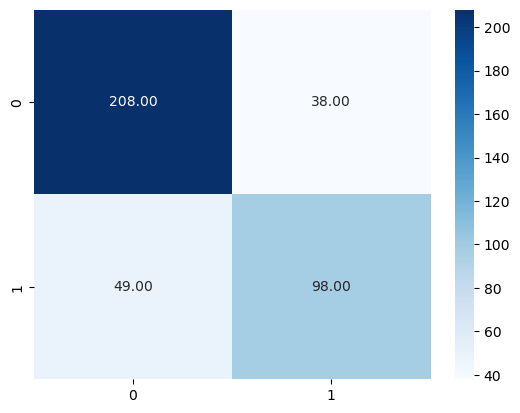

In [97]:
#Prediction

y_pred = NB_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = NB_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [98]:
model_list.append('Naive Bayes Classifier')
accuracy_score_list.append(ac)

In [99]:
probs = NB_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.820


In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       246
           1       0.72      0.67      0.69       147

    accuracy                           0.78       393
   macro avg       0.76      0.76      0.76       393
weighted avg       0.78      0.78      0.78       393



<h3> XG Boost </h3>

In [101]:
#Create pipeline
XGB_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
    ('classifier', XGBClassifier())
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
XGB_pipe.fit(X_train, y_train)


#GridSearch
##None

Pipeline(steps=[('imputer_age',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['age', 'fare'])),
                ('encoder_sex',
                 OneHotEncoder(drop_last=True, variables=['sex'])),
                ('discretiser_age',
                 DecisionTreeDiscretiser(cv=10, regression=False,
                                         scoring='accuracy',
                                         variables=['age'])),
                ('scaler',
                 RobustScaler(quantile_range=(0, 100), with_centering=False)),
                ('classifie...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Accuracy score: 0.8015267175572519


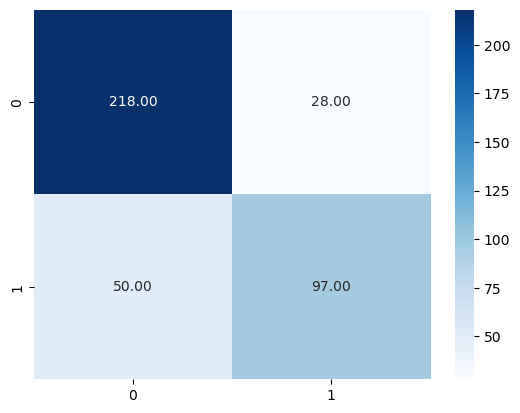

In [102]:
#Prediction

y_pred = XGB_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = XGB_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [103]:
model_list.append('XGBoost Classifier')
accuracy_score_list.append(ac)

In [104]:
probs = XGB_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.846


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       246
           1       0.78      0.66      0.71       147

    accuracy                           0.80       393
   macro avg       0.79      0.77      0.78       393
weighted avg       0.80      0.80      0.80       393



<h3> Ada Boost </h3>

In [106]:
#Create pipeline
Ada_pipe = Pipeline(steps = [
    ('imputer_age', MeanMedianImputer(imputation_method='mean', variables = ['age','fare'])),
    ('encoder_sex', OneHotEncoder(variables = ['sex'], drop_last = True)),
    ('discretiser_age',DecisionTreeDiscretiser(cv = 10, scoring = 'accuracy', variables = ['age'], regression = False)),
    ('scaler',RobustScaler(with_centering = False, with_scaling = True, quantile_range = (0, 100))),
     ('classifier', AdaBoostClassifier(n_estimators=50, learning_rate=0.5, algorithm='SAMME.R', random_state=1))
])

X_train = X_train_copy.copy()
X_test = X_test_copy.copy()

#Fit pipeline
Ada_pipe.fit(X_train, y_train)


#GridSearch
##None

Pipeline(steps=[('imputer_age',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['age', 'fare'])),
                ('encoder_sex',
                 OneHotEncoder(drop_last=True, variables=['sex'])),
                ('discretiser_age',
                 DecisionTreeDiscretiser(cv=10, regression=False,
                                         scoring='accuracy',
                                         variables=['age'])),
                ('scaler',
                 RobustScaler(quantile_range=(0, 100), with_centering=False)),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.5, random_state=1))])

Accuracy score: 0.7709923664122137


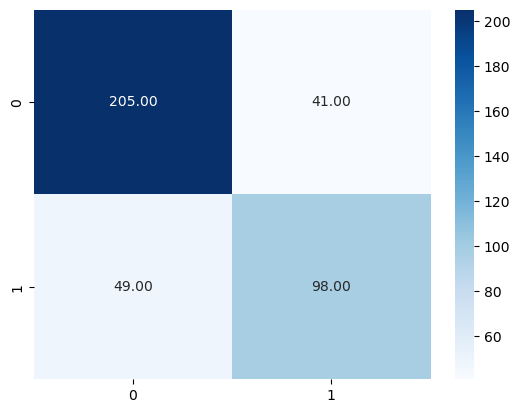

In [107]:
#Prediction

y_pred = Ada_pipe.predict(X_train)
act = accuracy_score(y_train, y_pred)
train_accuracy_score_list.append(act)

y_pred = Ada_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

ax = sns.heatmap(cm, annot=True,fmt='.2f', cmap='Blues')
print('Accuracy score:',ac)

In [108]:
model_list.append('AdaBoost Classifier')
accuracy_score_list.append(ac)

In [109]:
probs = Ada_pipe.predict_proba(X_test)
# save probability for true-positive
probs = probs[:, 1]
# ROC-AUC
auc = roc_auc_score(y_test, probs)
print('Model ROC-AUC=%.3f' % (auc))
roc_auc_list.append(auc)

Model ROC-AUC=0.838


In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       246
           1       0.71      0.67      0.69       147

    accuracy                           0.77       393
   macro avg       0.76      0.75      0.75       393
weighted avg       0.77      0.77      0.77       393



<center><h2> RESULTS </h2><center>

In [111]:
results = pd.DataFrame({'model': model_list,
                       'train_accuracy_score': train_accuracy_score_list,
                       'accuracy_score': accuracy_score_list,
                       'roc-auc_score': roc_auc_list}
                       )

In [112]:
results.sort_values(by = 'roc-auc_score', ascending = False)

,model,train_accuracy_score,accuracy_score,roc-auc_score
6,XGBoost Classifier,0.889738,0.801527,0.846164
7,AdaBoost Classifier,0.784934,0.770992,0.837896
4,Logistic Regression Classifier,0.783843,0.778626,0.830333
3,KNN Classifier,0.844978,0.783715,0.822936
5,Naive Bayes Classifier,0.751092,0.778626,0.819686
2,SVC Classifier,0.791485,0.788804,0.819603
1,Random Forest Classifier,0.894105,0.786260,0.806745
0,Decision Tree Classifier,0.900655,0.798982,0.784954


(0.75, 0.91)

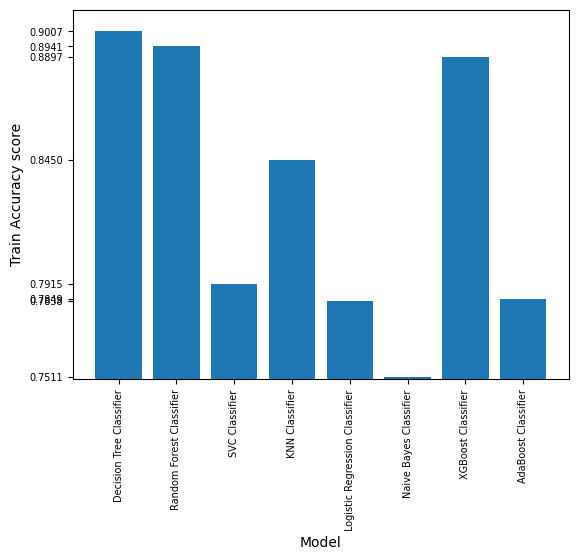

In [113]:
plt.bar(results['model'], results['train_accuracy_score'])
plt.xticks(results['model'],rotation = 90, fontsize = 7)
plt.yticks(results['train_accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Train Accuracy score')
plt.ylim(0.75, 0.91)

(0.77, 0.81)

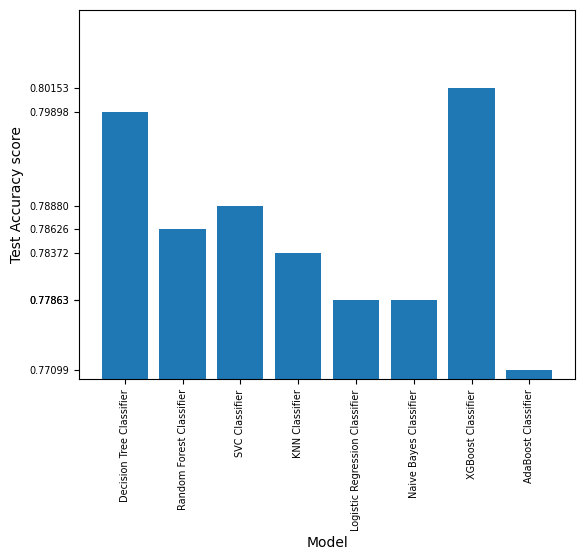

In [114]:
plt.bar(results['model'], results['accuracy_score'])
plt.xticks(results['model'],rotation = 90, fontsize = 7)
plt.yticks(results['accuracy_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('Test Accuracy score')
plt.ylim(0.77, 0.81)

(0.77, 0.85)

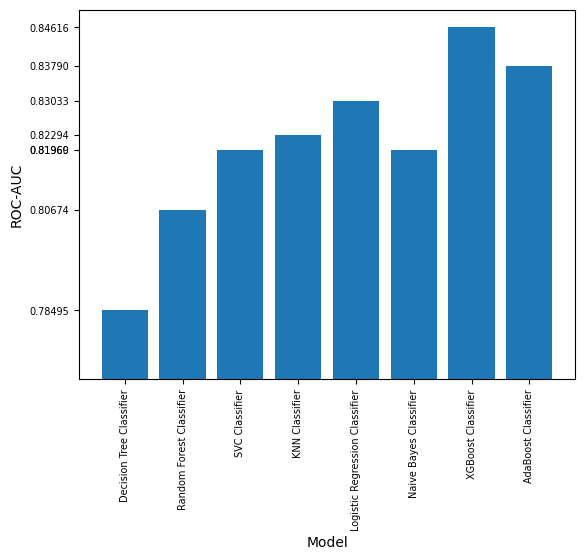

In [115]:
plt.bar(results['model'], results['roc-auc_score'])
plt.xticks(results['model'],rotation = 90, fontsize = 7)
plt.yticks(results['roc-auc_score'], fontsize = 7)
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.ylim(0.77, 0.85)

According to the accuracy score for test set ( accuracy score is less than 90%), comparison of train/test accuracy score (difference is less than 1.5%) and ROC-AUC (above 83%) for test set <b> AdaBoost Classifier </b> was chosen as the best classification model.